## Análisis de fairness en el dataset de German Credit


### Objetivo
El objetivo de este proyecto es analizar el desempeño de un modelo de aprendizaje automático aplicado a un problema de aprobación de créditos y evaluar su equidad respecto de una variable sensible, utilizando el conjunto de datos German Credit.
Se estudia el comportamiento del modelo antes y después de aplicar técnicas de mitigación, analizando los trade-offs entre performance y equidad.


### EDA
El conjunto de datos contiene información sobre solicitantes de crédito, junto con una variable objetivo que indica si el perfil es bueno o no como para otorgarle un crédito.


In [61]:
# %pip install holisticai[all]

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.ticker as ticker
import numpy as np

In [63]:
from ucimlrepo import fetch_ucirepo
#Carga del dataset "Statlog (German Credit Data)" desde UCI Machine Learning Repository
statlog_german_credit_data = fetch_ucirepo(id=144)
df = statlog_german_credit_data.data.original

#Cambios de nombres de columnas para mayor claridad
df = df.rename(columns={
    'Attribute1': 'estado_cuenta_corriente',    
    'Attribute2': 'duracion_meses',              
    'Attribute3': 'historial_crediticio',        
    'Attribute4': 'proposito',                  
    'Attribute5': 'monto_credito',              
    'Attribute6': 'cuenta_ahorro_bonos',         
    'Attribute7': 'años_empleo',                
    'Attribute8': 'porc_ingreso_disponible',    
    'Attribute9': 'estado_civil_sexo',           
    'Attribute10': 'otros_deudores_garantes',   
    'Attribute11': 'residencia_actual_anios',   
    'Attribute12': 'propiedad',                  
    'Attribute13': 'edad',                       
    'Attribute14': 'otros_creditos',            
    'Attribute15': 'vivienda',                  
    'Attribute16': 'num_creditos_banco',         
    'Attribute17': 'ocupacion',                  
    'Attribute18': 'num_personas_a_cargo',       
    'Attribute19': 'telefono',                   
    'Attribute20': 'trabajador_extranjero',     
    'class': 'riesgo_crediticio'                 #Target
})
#df.info()

In [64]:
#Diccionarios para interpretar los valores del dataset 
valores_unicos = {
    "estado_cuenta_corriente": {
        "A11": "negativo",
        "A12": "0-200 DM",
        "A13": "+ 200 DM / salario de 1 año",
        "A14": "no tiene"
    },
    "historial_crediticio": {
        "A30": "no tomo creditos/todos los creditos pagados",
        "A31": "todos los creditos en este banco pagados",
        "A32": "creditos existentes pagados hasta ahora",
        "A33": "retraso en pagos en el pasado",
        "A34": "cuenta critica/ otros creditos existentes" #Otros credditos existentes: en otro banco
    },
    "proposito": {
        "A40": "auto (nuevo)",
        "A41": "auto (usado)",
        "A42": "muebles/equipos",
        "A43": "radio/televisión",
        "A44": "electrodomésticos",
        "A45": "reparaciones",
        "A46": "educación",
        "A47": "vacaciones",
        "A48": "reentrenamiento",
        "A49": "negocios",
        "A410": "otros"
    },
    "cuenta_ahorro_bonos": {
        "A61": "0 - 100 DM",
        "A62": "100 - 500 DM",
        "A63": "500 - 1000 DM",
        "A64": "+1000 DM",
        "A65": "desconocido/ no tiene"
    },
    "años_empleo": {
        "A71": "desempleado",
        "A72": "< 1 año",
        "A73": "1 - 3 años",
        "A74": "4 - 6 años",
        "A75": ">= 7 años"
    },
    "estado_civil_sexo": {
        "A91": "hombre : divorciado/separado",
        "A92": "mujer : divorciada/separada/casada",
        "A93": "hombre : soltero",
        "A94": "hombre : casado/viudo",
        "A95": "mujer : soltera"
    },
    "otros_deudores_garantes": {
        "A101": "ninguno",
        "A102": "co-solicitante",
        "A103": "garante"
    },
    "propiedad": {
        "A121": "bienes raíces",
        "A122": "acuerdo de ahorro de sociedad de construcción/ seguro de vida",
        "A123": "auto u otro",
        "A124": "desconocido /no tiene"
    },
    "otros_creditos": {
        "A141": "banco",
        "A142": "tiendas",
        "A143": "ninguno"
    },
    "vivienda": {
        "A151": "alquiler",
        "A152": "propio",
        "A153": "gratis"
    },
    "ocupacion": {
        "A171": "desempleado/ no calificado - no residente",
        "A172": "no calificado - residente",
        "A173": "empleado calificado / oficial",
        "A174": "gerencia/ autónomo/ empleado altamente calificado/ oficial"
    },
    "telefono": {
        "A191": "ninguno",
        "A192": "sí, registrado a nombre del cliente"
    },
    "trabajador_extranjero": {
        "A201": "sí",
        "A202": "no"
    }
}


Los features estan divididos en tres grupos excluyendo el target:

- Relacionados al historial cerediticio/situacion económica
- Relacionados al credito solicitado 
- Relacionados al cliente 

Estos grupos refieren a lo que estos atributos nos dicen de la instancia. Los relacionados al cliente son los atributos personales, o proxys de ellos, y por ende los atributos sensibles que pueden originar un sesgo. Por ejemplo, si bien los años de empleo o la propiedad no son sensibles y tiene sentido que sean evaluados en un analisis economico, una combinacion de todo esto puede significar clase social, y por ende generar un sesgo socioeconómico.

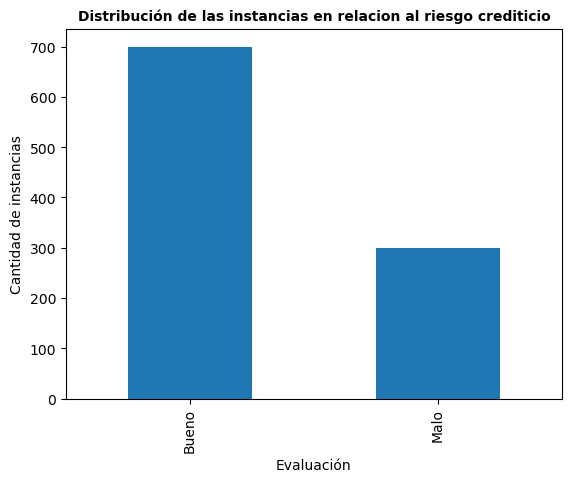

In [65]:
#Columna target
target = df["riesgo_crediticio"]
target = df["riesgo_crediticio"].map({1: "Bueno", 2: "Malo"})

target.value_counts().plot(kind="bar")
plt.xlabel("Evaluación")
plt.ylabel("Cantidad de instancias")
plt.title("Distribución de las instancias en relacion al riesgo crediticio", fontsize=10, fontweight='bold')
plt.show()

#print(target.value_counts())


In [66]:
#Separacion de columnas categoricas y numericas
columnas_categoricas = ['años_empleo', 'estado_civil_sexo',  'vivienda', 'propiedad',  'ocupacion', 'telefono', 'trabajador_extranjero']
columnas_numericas = ['residencia_actual_anios', 'edad', 'num_personas_a_cargo']

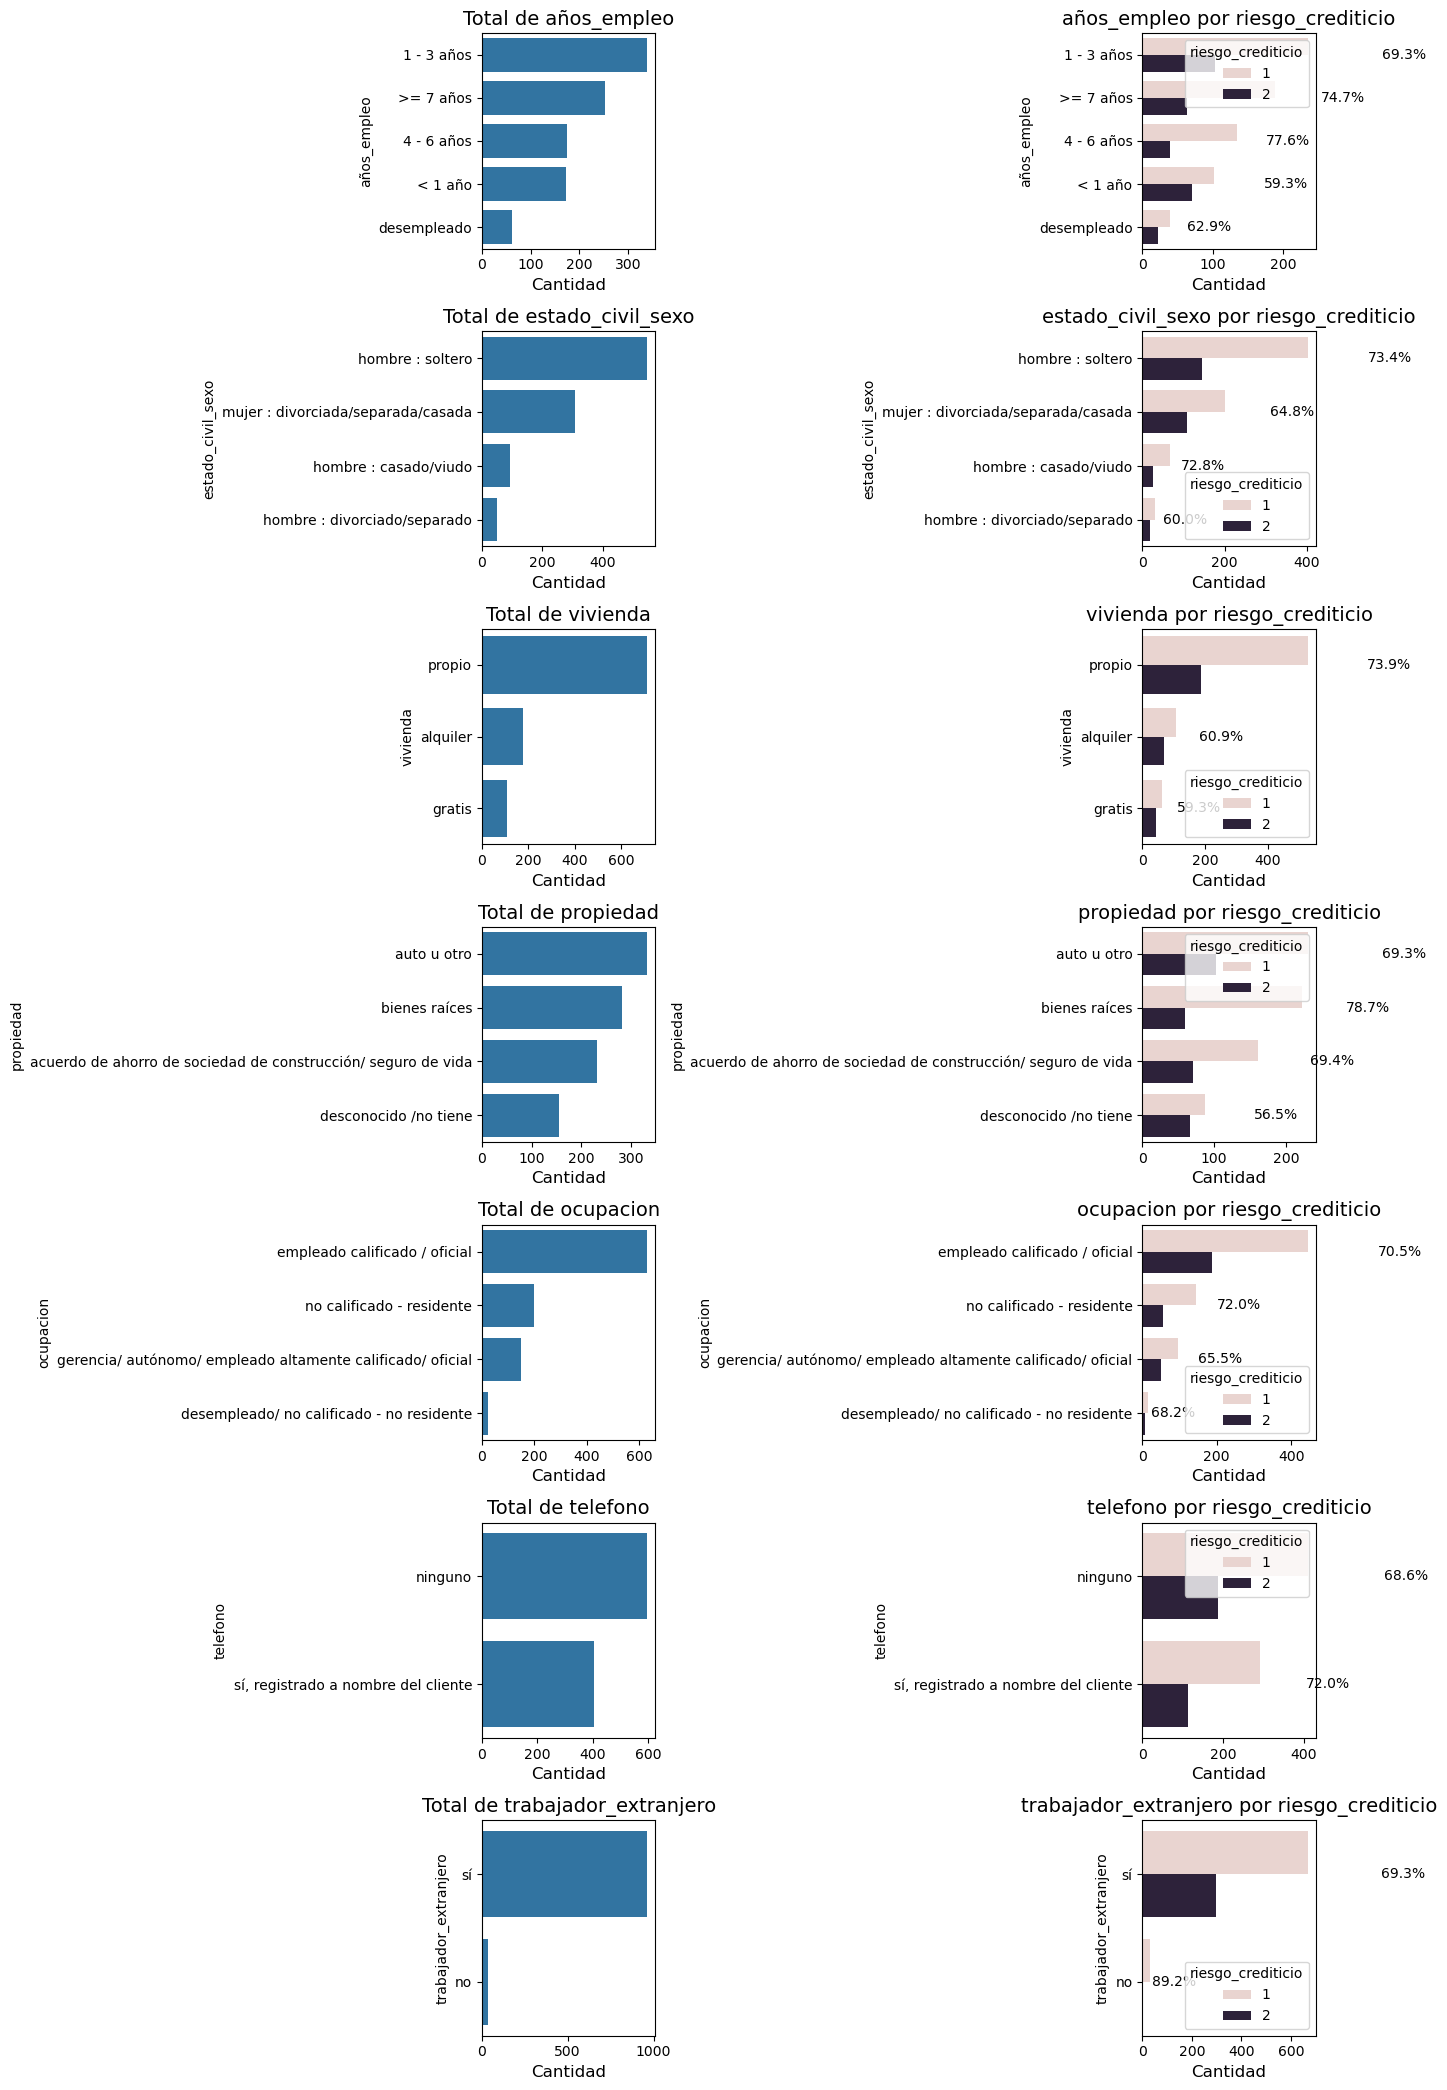

In [67]:
n_cols = 2  
n_rows = len(columnas_categoricas)

plt.figure(figsize=(8 * n_cols, 3 * n_rows))

for i, col in enumerate(columnas_categoricas):
    # Gráfico 1: Total por categoría
    plt.subplot(n_rows, n_cols, i * n_cols + 1)

    order = df[col].value_counts().index
    ax1 = sns.countplot(y=col, data=df, order=order)

    etiquetas_codigos = [tick.get_text() for tick in ax1.get_yticklabels()]
    if col in valores_unicos:
        etiquetas_descriptivas = [valores_unicos[col].get(codigo, codigo) for codigo in etiquetas_codigos]
    else:
        etiquetas_descriptivas = etiquetas_codigos

    posiciones_ticks = ax1.get_yticks()
    ax1.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax1.set_yticklabels(etiquetas_descriptivas, fontsize=10)

    ax1.set_title(f'Total de {col}', fontsize=14)
    ax1.set_xlabel('Cantidad', fontsize=12)

    # Gráfico 2: Distribución por riesgo_crediticio con % de positivos
    plt.subplot(n_rows, n_cols, i * n_cols + 2)

    ax2 = sns.countplot(y=col, hue="riesgo_crediticio", data=df, order=order)
    
    posiciones_ticks = ax2.get_yticks()
    ax2.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax2.set_yticklabels(etiquetas_descriptivas, fontsize=10)

    ax2.set_title(f'{col} por riesgo_crediticio', fontsize=14)
    ax2.set_xlabel('Cantidad', fontsize=12)
    ax2.legend(title='riesgo_crediticio')

    # Cálculo del % de positivos por categoría
    for j, categoria in enumerate(order):
        subset = df[df[col] == categoria]
        total = len(subset)
        positivos = len(subset[subset['riesgo_crediticio'] == 1])
        porcentaje = (positivos / total) * 100 if total > 0 else 0

        x_pos = subset[col].value_counts().max() + 1
        y_pos = j

        ax2.text(x_pos, y_pos, f"{porcentaje:.1f}%", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [68]:
#variable sensible "trabajador_extranjero" en relación a "ocupacion" 
print(df[df['ocupacion'] == "A172"]["trabajador_extranjero"].value_counts()) 
print(df[df['ocupacion'] == "A171"]["trabajador_extranjero"].value_counts()) 

trabajador_extranjero
A201    186
A202     14
Name: count, dtype: int64
trabajador_extranjero
A201    20
A202     2
Name: count, dtype: int64


In [69]:
# modificamos sexo / estado civil porque el dataset esta codificado de forma conjunta y no es claro
map_sexo = {'A91': 'male', 'A92': 'female', 'A93': 'male', 'A94': 'male', 'A95': 'female'}

map_estado_civil = {'A91': 'not_single', 'A92': 'not_single', 'A93': 'single', 'A94': 'not_single', 'A95': 'single'}

df['estado_civil'] = df['estado_civil_sexo'].map(map_estado_civil)
df['sexo'] = df['estado_civil_sexo'].map(map_sexo)

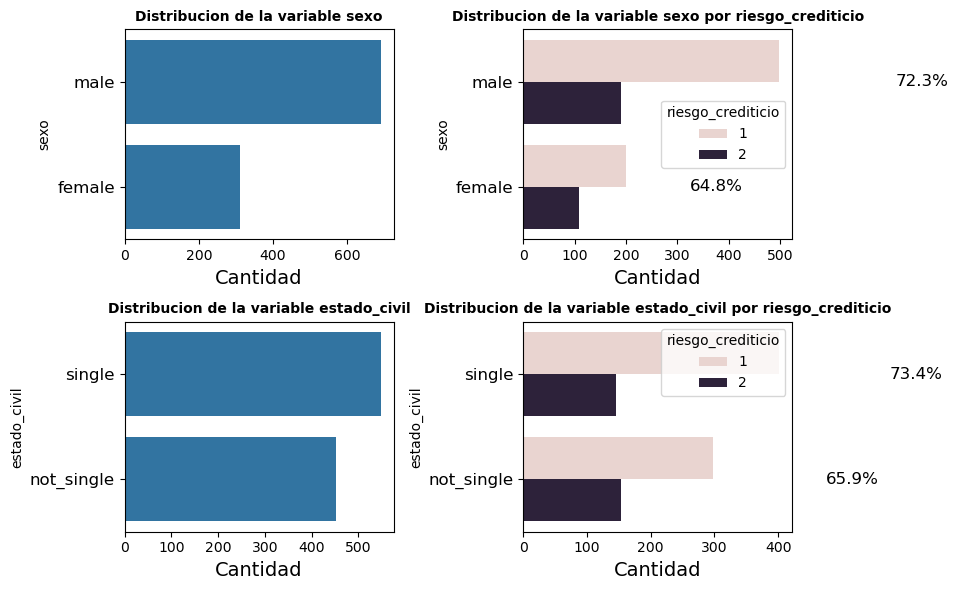

In [70]:
columnas_plot = ['sexo', 'estado_civil']
n_cols = 2  
n_rows = len(columnas_plot)

plt.figure(figsize=(5 * n_cols, 3 * n_rows))  

for i, col in enumerate(columnas_plot):
    # Gráfico 1: Total por categoría
    plt.subplot(n_rows, n_cols, i * n_cols + 1)

    order = df[col].value_counts().index
    ax1 = sns.countplot(y=col, data=df, order=order)

    etiquetas_codigos = [tick.get_text() for tick in ax1.get_yticklabels()]
    if col in valores_unicos:
        etiquetas_descriptivas = [valores_unicos[col].get(codigo, codigo) for codigo in etiquetas_codigos]
    else:
        etiquetas_descriptivas = etiquetas_codigos

    posiciones_ticks = ax1.get_yticks()
    ax1.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax1.set_yticklabels(etiquetas_descriptivas, fontsize=12)

    ax1.set_title(f'Distribucion de la variable {col}', fontsize=10,fontweight='bold')
    ax1.set_xlabel('Cantidad', fontsize=14)

    # Gráfico 2: Distribución por riesgo_crediticio con % de positivos
    plt.subplot(n_rows, n_cols, i * n_cols + 2)

    ax2 = sns.countplot(y=col, hue="riesgo_crediticio", data=df, order=order)

    posiciones_ticks = ax2.get_yticks()
    ax2.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax2.set_yticklabels(etiquetas_descriptivas, fontsize=12)
    ax2.set_title(f'Distribucion de la variable {col} por riesgo_crediticio', fontsize=10, fontweight='bold')
    ax2.set_xlabel('Cantidad', fontsize=14)
    ax2.legend(title='riesgo_crediticio')

    for j, categoria in enumerate(order):
        subset = df[df[col] == categoria]
        total = len(subset)
        positivos = len(subset[subset['riesgo_crediticio'] == 1])
        porcentaje = (positivos / total) * 100 if total > 0 else 0

        count_categoria = subset[col].value_counts().max()
        x_pos = count_categoria + count_categoria * 0.05  
        y_pos = j

        ax2.text(x_pos, y_pos, f"{porcentaje:.1f}%", va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()
#Recordamos que el 1 es buen riesgo crediticio y el 2 es mal riesgo crediticio


Para estado_civil_sexo, la columna presenta dos tipos de sesgo. En primer lugar tenemos posibles sesgos historicos relacionados con el sexo o el estado civil, que perpetuan diferencias en las oportunidades que tienen ciertos grupos sociales. Por otro lado, tambien hay un problema con la codificación de datos. Mas allá de que mezclar sexo y estado civil no es una buena practiva, para el sexo femenino tenemos dos categorias de estado civil, soltera y casada/divorcida/separada, mientras que para hombre tenemos tres, soltero, casado/viudo y divorciado/separado. El atributo de sexo-estado_civil debería tener todas las combinaciones.
Se intenta resolver el problema mencionado separando en soltero / no soltero para aprovechar las categorias comunes a ambos sexos y evitar los proxys. Estamos probablemente introduciendo un sesgo de codificacion de datos al manipular las categorias, pero nos parece que vale la pena y es necesario para poder lograr una mejor interpretacion.

Por otro lado, la columna trabajador_extranjero podria indicar que hay/puede existir un sesgo por discriminaciones sistematicas. El racismo/xenofobia podria verse integrado en las practicas sociales, llevando a que una persona estranjera no tenga la posibilidad de acceso a un préstamo. Tambien, por praticas historicas, su historial crediticio podria verse afectado.

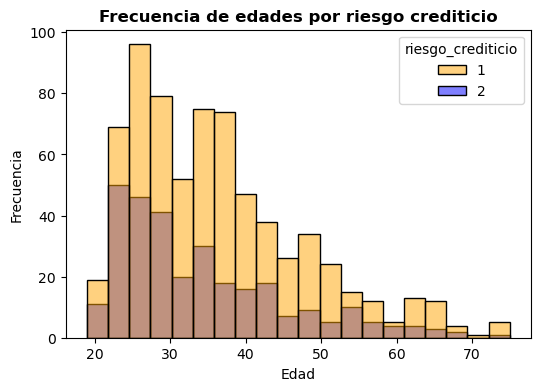

In [71]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='edad', hue='riesgo_crediticio', bins=20, kde=False, palette=['orange', 'blue'])
plt.title('Frecuencia de edades por riesgo crediticio', fontsize=12, fontweight='bold')
plt.xlabel('Edad', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.show()

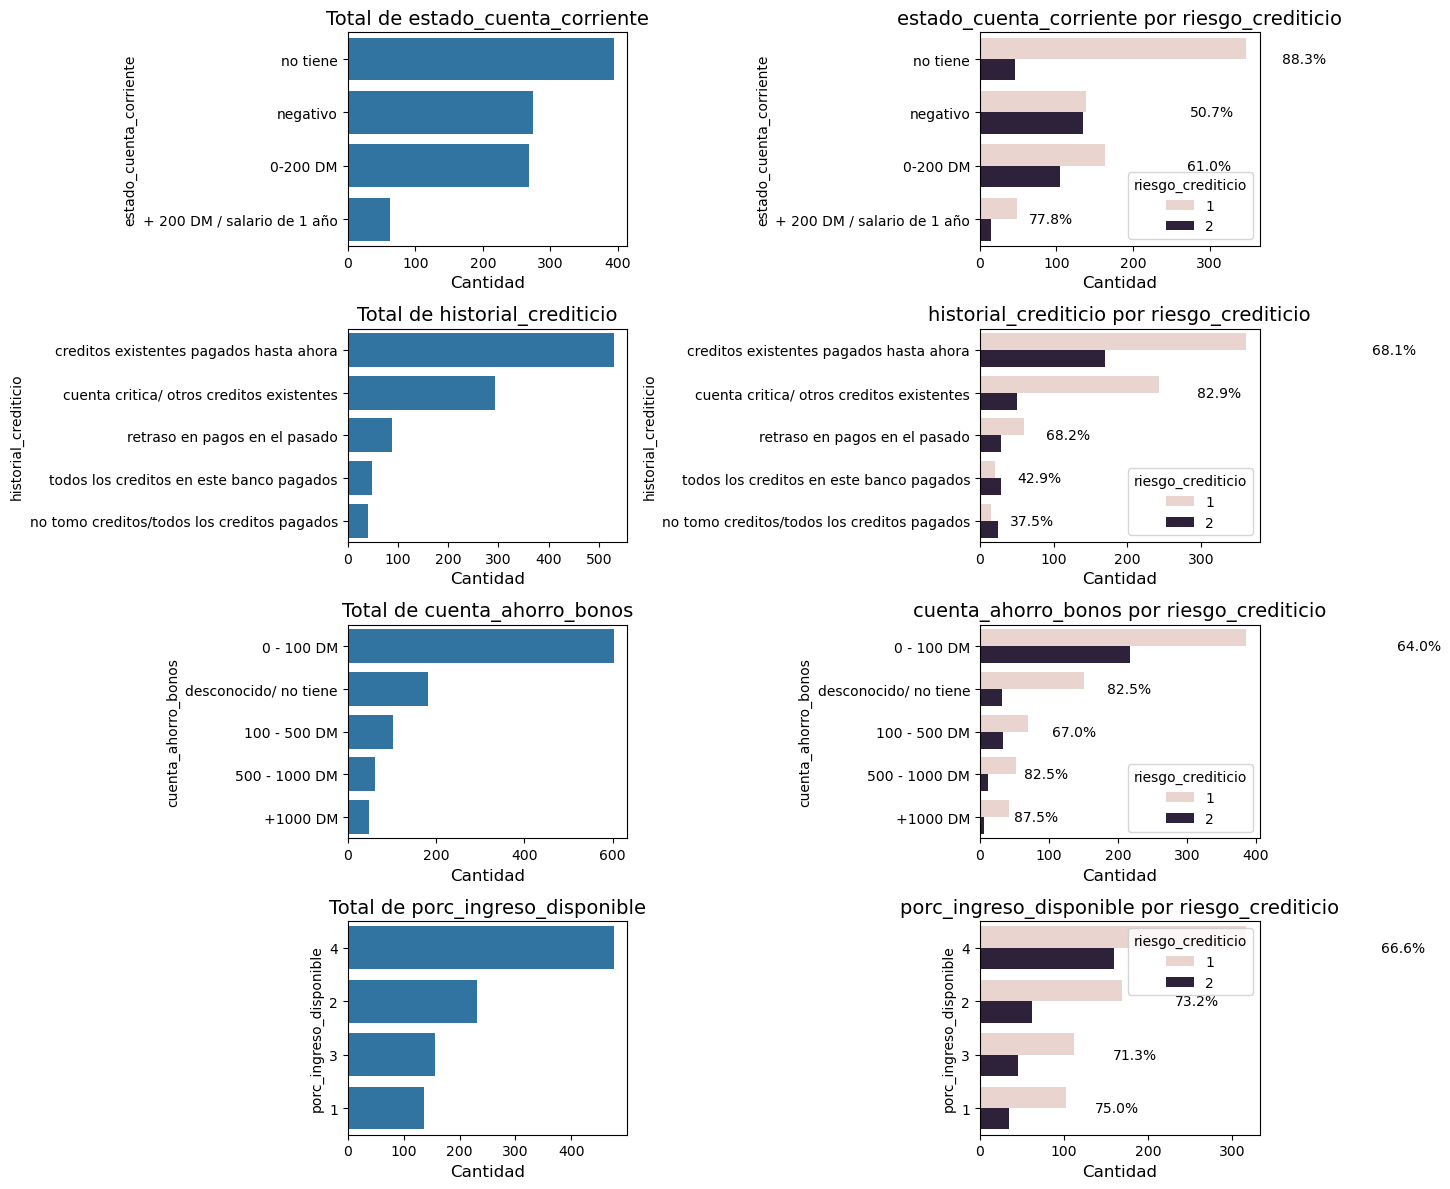

In [72]:
#Analisis de las columnas categoricas no sensibles
columnas_categoricas = ['estado_cuenta_corriente', 'historial_crediticio', 'cuenta_ahorro_bonos', 'porc_ingreso_disponible']

n_cols = 2  
n_rows = len(columnas_categoricas)

plt.figure(figsize=(8 * n_cols, 3 * n_rows))

for i, col in enumerate(columnas_categoricas):
    # Gráfico 1: Total por categoría
    plt.subplot(n_rows, n_cols, i * n_cols + 1)

    order = df[col].value_counts().index
    ax1 = sns.countplot(y=col, data=df, order=order)

    etiquetas_codigos = [tick.get_text() for tick in ax1.get_yticklabels()]
    if col in valores_unicos:
        etiquetas_descriptivas = [valores_unicos[col].get(codigo, codigo) for codigo in etiquetas_codigos]
    else:
        etiquetas_descriptivas = etiquetas_codigos

    posiciones_ticks = ax1.get_yticks()
    ax1.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax1.set_yticklabels(etiquetas_descriptivas, fontsize=10)

    ax1.set_title(f'Total de {col}', fontsize=14)
    ax1.set_xlabel('Cantidad', fontsize=12)

    # Gráfico 2: Distribución por riesgo_crediticio con % de positivos
    plt.subplot(n_rows, n_cols, i * n_cols + 2)

    ax2 = sns.countplot(y=col, hue="riesgo_crediticio", data=df, order=order)
    
    posiciones_ticks = ax2.get_yticks()
    ax2.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax2.set_yticklabels(etiquetas_descriptivas, fontsize=10)

    ax2.set_title(f'{col} por riesgo_crediticio', fontsize=14)
    ax2.set_xlabel('Cantidad', fontsize=12)
    ax2.legend(title='riesgo_crediticio')

    # Cálculo del % de positivos por categoría
    for j, categoria in enumerate(order):
        subset = df[df[col] == categoria]
        total = len(subset)
        positivos = len(subset[subset['riesgo_crediticio'] == 1])
        porcentaje = (positivos / total) * 100 if total > 0 else 0

        x_pos = subset[col].value_counts().max() + 1
        y_pos = j

        ax2.text(x_pos, y_pos, f"{porcentaje:.1f}%", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

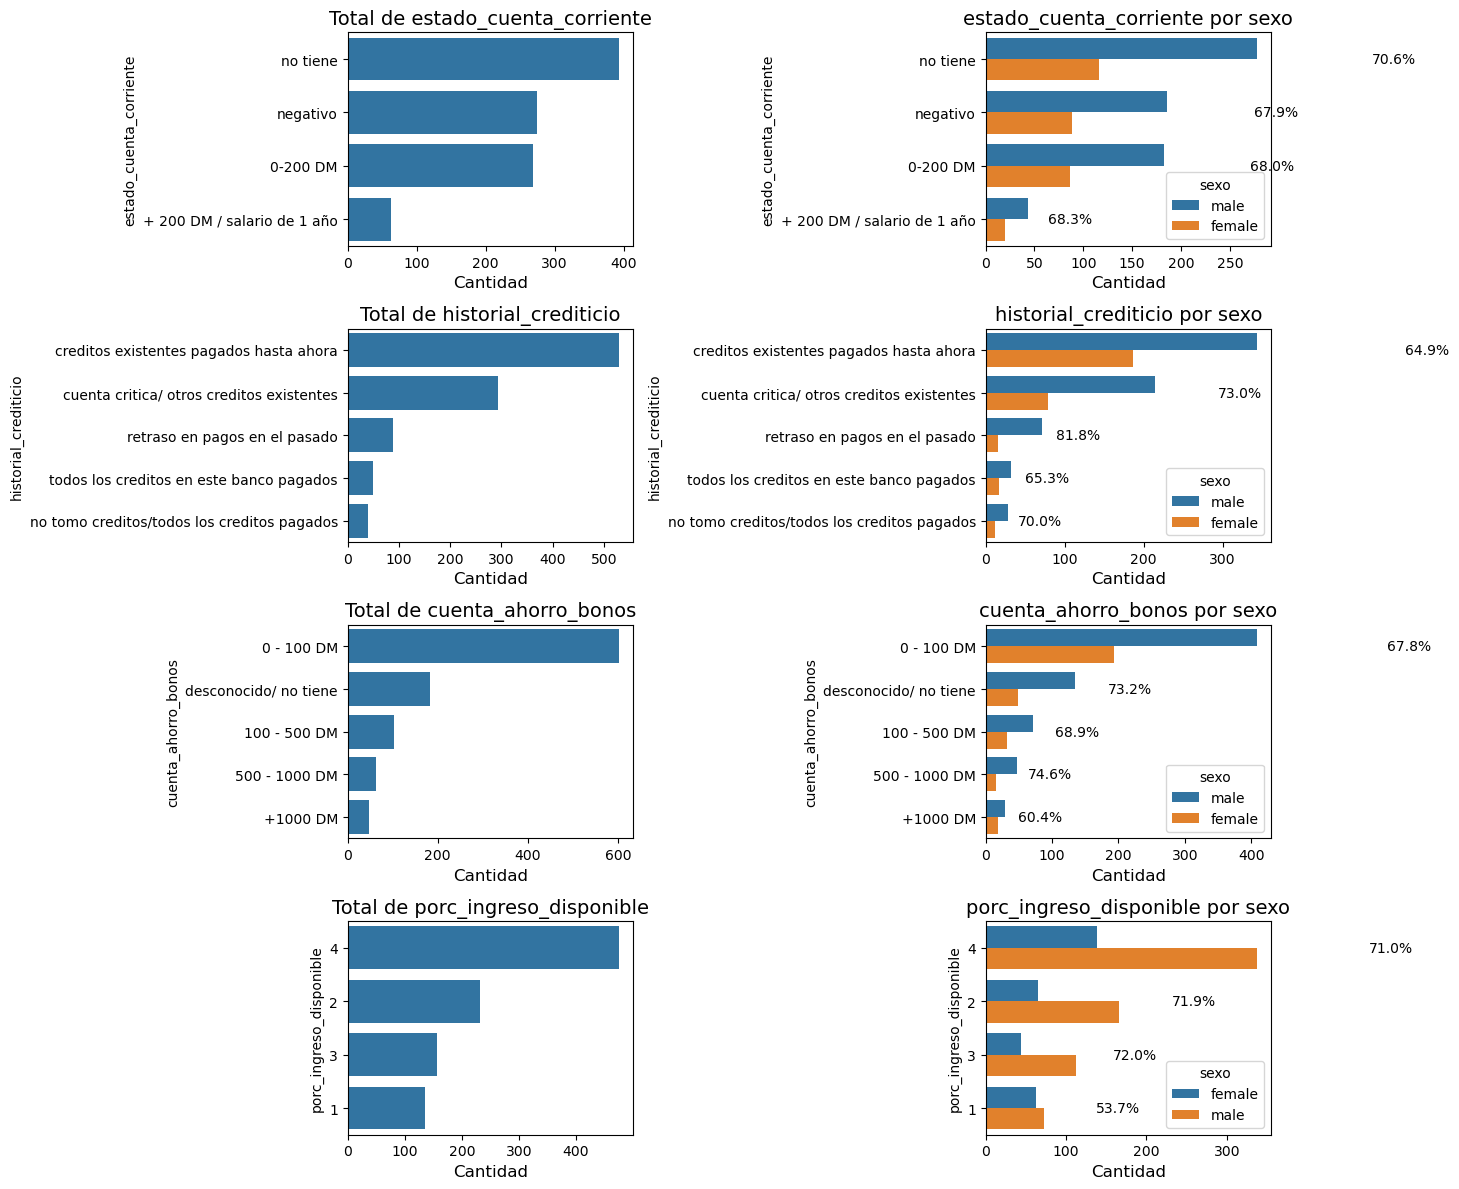

In [73]:
#Realizamos el mismo analisis pero ahora con la variable sensible "sexo"
plt.figure(figsize=(8 * n_cols, 3 * n_rows))

for i, col in enumerate(columnas_categoricas):
    # Gráfico 1: Total por categoría
    plt.subplot(n_rows, n_cols, i * n_cols + 1)

    order = df[col].value_counts().index
    ax1 = sns.countplot(y=col, data=df, order=order)

    etiquetas_codigos = [tick.get_text() for tick in ax1.get_yticklabels()]
    if col in valores_unicos:
        etiquetas_descriptivas = [valores_unicos[col].get(codigo, codigo) for codigo in etiquetas_codigos]
    else:
        etiquetas_descriptivas = etiquetas_codigos

    posiciones_ticks = ax1.get_yticks()
    ax1.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax1.set_yticklabels(etiquetas_descriptivas, fontsize=10)

    ax1.set_title(f'Total de {col}', fontsize=14)
    ax1.set_xlabel('Cantidad', fontsize=12)

    # Gráfico 2: Distribución por riesgo_crediticio con % de positivos
    plt.subplot(n_rows, n_cols, i * n_cols + 2)

    ax2 = sns.countplot(y=col, hue="sexo", data=df, order=order)
    
    posiciones_ticks = ax2.get_yticks()
    ax2.yaxis.set_major_locator(ticker.FixedLocator(posiciones_ticks))
    ax2.set_yticklabels(etiquetas_descriptivas, fontsize=10)

    ax2.set_title(f'{col} por sexo', fontsize=14)
    ax2.set_xlabel('Cantidad', fontsize=12)
    ax2.legend(title='sexo')

    # Cálculo del % de positivos por categoría
    for j, categoria in enumerate(order):
        subset = df[df[col] == categoria]
        total = len(subset)
        positivos = len(subset[subset['sexo'] == 'male'])
        porcentaje = (positivos / total) * 100 if total > 0 else 0

        x_pos = subset[col].value_counts().max() + 1
        y_pos = j

        ax2.text(x_pos, y_pos, f"{porcentaje:.1f}%", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

No hay una relacion directa que se pueda observar a simple vista, porque la mayoria de las instancias son masculinas y por ende tiene sentido que sean un % mayor de cada categoria. Es simplemente algo a notar

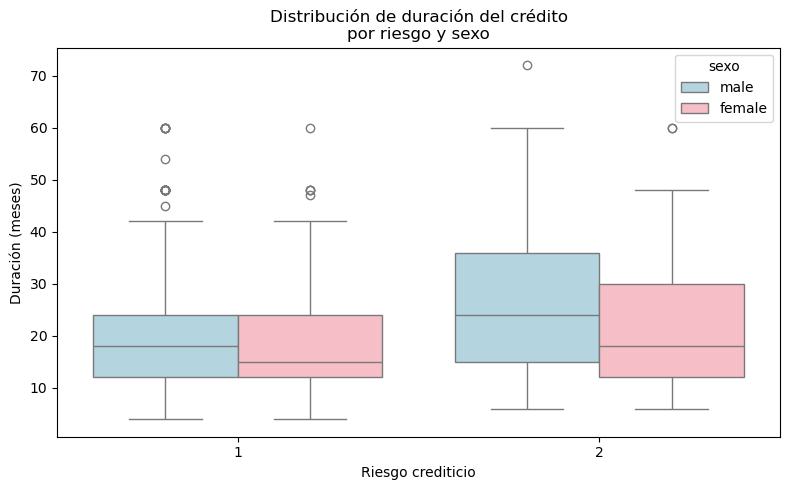

In [74]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=df, x="riesgo_crediticio", y="duracion_meses", hue="sexo",palette=['lightblue', 'lightpink'])

plt.title("Distribución de duración del crédito\npor riesgo y sexo")
plt.xlabel("Riesgo crediticio")
plt.ylabel("Duración (meses)")
plt.tight_layout()
plt.show()


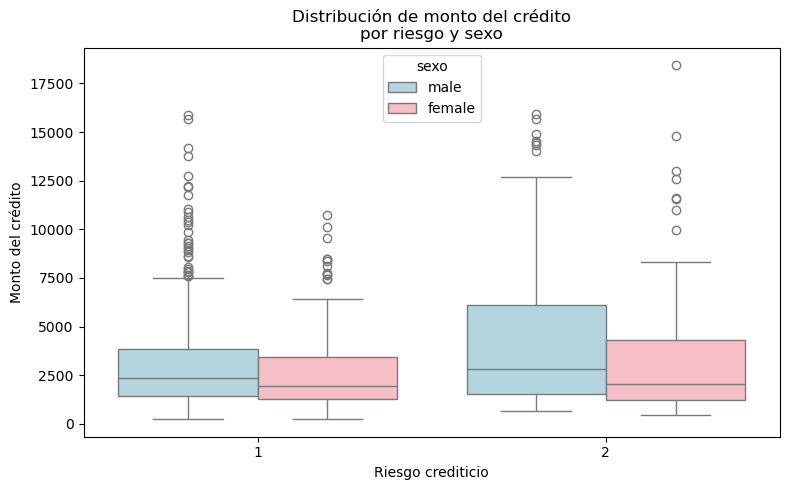

In [75]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=df, x="riesgo_crediticio", y="monto_credito", hue="sexo", palette=['lightblue', 'lightpink'])

plt.title("Distribución de monto del crédito\npor riesgo y sexo")
plt.xlabel("Riesgo crediticio")
plt.ylabel("Monto del crédito")
plt.tight_layout()
plt.show()


In [76]:
#df = df.drop(columns=['proposito', 'otros_deudores_garantes', 'duracion_meses', 'monto_credito'])

### Modelo

En primer lugar, vamos a transformar el dataset utilizando one-hot encoding para que el clasificador pueda procesarlo correctamente. 

In [86]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.calibration import cross_val_predict
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import make_pipeline        

In [87]:
features_encoded = pd.get_dummies(df, dtype=int)

In [88]:
#Guardamos los datos ¿ por sexo, para despues poder analizar si esta sesgado por ese atributo
print(features_encoded['sexo_female'].value_counts())
print(features_encoded['sexo_male'].value_counts())
 
data_fem = features_encoded[features_encoded['sexo_female'] == 1] 
data_male = features_encoded[features_encoded['sexo_male'] == 1]

sexo_female
0    690
1    310
Name: count, dtype: int64
sexo_male
1    690
0    310
Name: count, dtype: int64


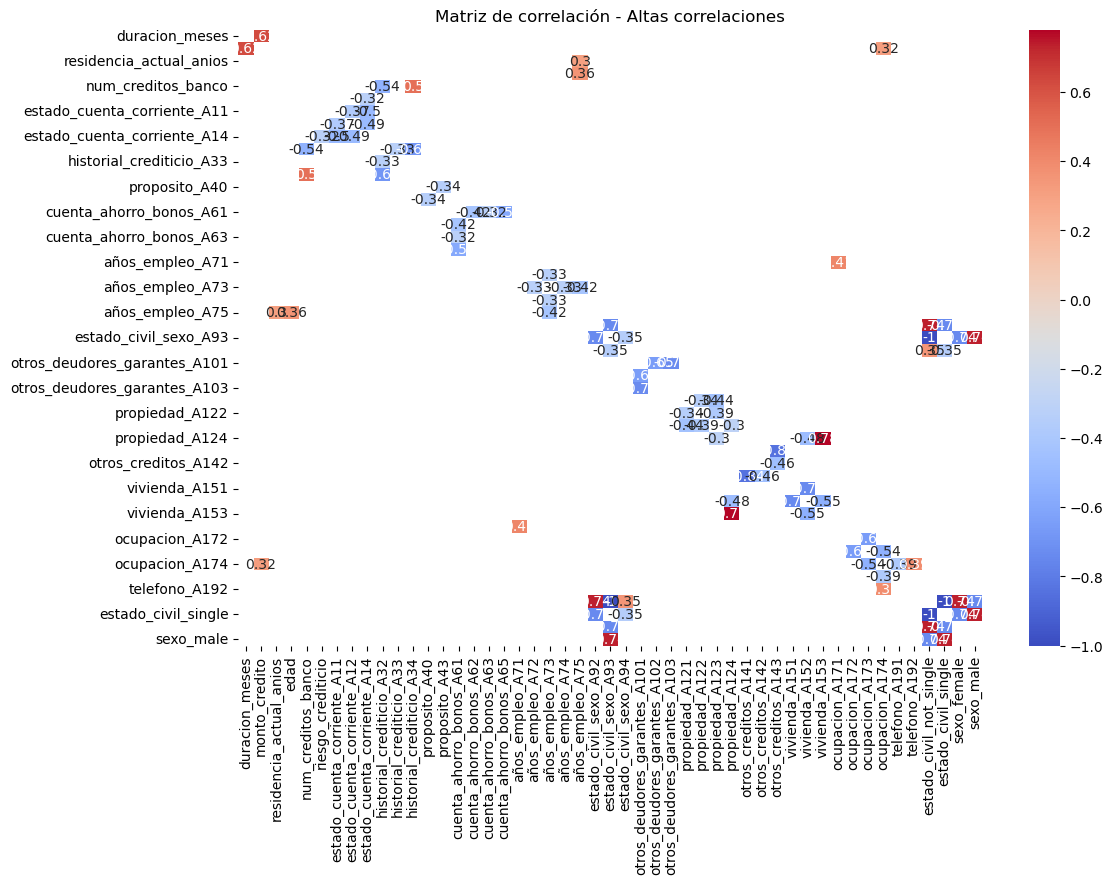

In [89]:
#Armamos una matriz de correlacion (su version legible), para ir teniendo idea de que atributos estan relacionados
corr = features_encoded.corr()
umbral = 0.3
high_corr_cols = corr[(corr.abs() > umbral) & (corr.abs() < 1)].dropna(how="all", axis=1).dropna(how="all", axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(high_corr_cols, annot=True, cmap='coolwarm')

plt.title('Matriz de correlación - Altas correlaciones')
plt.show()


In [90]:
Y = features_encoded['riesgo_crediticio']
Y = Y.replace(2,0)
X = features_encoded.drop(columns=['riesgo_crediticio'])


Siendo que planeamos usar validacion cruzada para tener una mejor idea del valor real de las metricas, creamos nuestras propias funciones de scoring, con las metricas relevantes para los criterios de fairnes.

Documentacion: https://scikit-learn.org/stable/modules/cross_validation.html

De esto viene tambien el cambiar la variable negativa de 2 a 0, ya que sklearn no podia interpretar correctamente la clase positiva y negativa

In [91]:
def tpr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn) if (tp + fn) else 0

def tnr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) else 0

def ppv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fp) if (tp + fp) else 0

scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'tpr': make_scorer(tpr_score),
    'tnr': make_scorer(tnr_score),
    'ppv': make_scorer(ppv_score)
}

In [92]:
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

y_pred = cross_val_predict(clf, X, Y, cv=cv)
cm = confusion_matrix(Y, y_pred)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

print("----- Matriz de Confusión -----", end='\n\n')

print(f'                | {"Pred. Positiva":^15} | {"Pred. Negativa":^15} |')
print(f'{"Real Positiva":^15} | {TP:^15} | {FN:^15} |')
print(f'{"Real Negativa":^15} | {FP:^15} | {TN:^15} |')

results = cross_validate(clf, X, Y, cv=cv, scoring=scoring)
 
print("\n----- Métricas de Evaluación -----", end='\n\n')
print(f"Precisión: {round(results['test_precision'].mean(), 2)} - {round(results['test_precision'].std(), 2)}")
print(f"Recall: {round(results['test_recall'].mean(),2)} - {round(results['test_recall'].std(), 2)}")
print(f"Accuracy: {round(results['test_accuracy'].mean(),2)} - {round(results['test_accuracy'].std(), 2)}")
print(f"F1-score: {round(results['test_f1'].mean(),2)} - {round(results['test_f1'].std(), 2)}")
print(f"True positive rate (TPR): {round(results['test_tpr'].mean(),2)} - {round(results['test_tpr'].std(), 2)}")
print(f"True negative rate (TNR): {round(results['test_tnr'].mean(),2)} -  {round(results['test_tnr'].std(), 2)}")
print(f"Positive predictive value (PPV): {round(results['test_ppv'].mean(),2)} - {round(results['test_ppv'].std(), 2)}")

----- Matriz de Confusión -----

                | Pred. Positiva  | Pred. Negativa  |
 Real Positiva  |       631       |       69        |
 Real Negativa  |       177       |       123       |

----- Métricas de Evaluación -----

Precisión: 0.77 - 0.02
Recall: 0.9 - 0.03
Accuracy: 0.75 - 0.02
F1-score: 0.83 - 0.01
True positive rate (TPR): 0.9 - 0.03
True negative rate (TNR): 0.38 -  0.07
Positive predictive value (PPV): 0.77 - 0.02


Armamos un segundo modelo, que sea regresor logistico, para analizar cual nos da mejores metricas y analizar con cual nos quedamos como modelo final para analizar la equidad

In [121]:
log_clf_pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=33, max_iter=1000))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13) 
y_pred = cross_val_predict(log_clf_pipeline, X, Y, cv=cv)
cm = confusion_matrix(Y, y_pred)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

print("----- Matriz de Confusión -----", end='\n\n')

print(f'                | {"Pred. Positiva":^15} | {"Pred. Negativa":^15} |')
print(f'{"Real Positiva":^15} | {TP:^15} | {FN:^15} |')
print(f'{"Real Negativa":^15} | {FP:^15} | {TN:^15} |')


results = cross_validate(log_clf_pipeline, X, Y, cv=cv, scoring=scoring)
 
print("\n----- Métricas de Evaluación -----", end='\n\n')

print(f"Precisión: {round(results['test_precision'].mean(), 2)} - {round(results['test_precision'].std(), 2)}")
print(f"Recall: {round(results['test_recall'].mean(),2)} - {round(results['test_recall'].std(), 2)}")
print(f"Accuracy: {round(results['test_accuracy'].mean(),2)} - {round(results['test_accuracy'].std(), 2)}")
print(f"F1-score: {round(results['test_f1'].mean(),2)} - {round(results['test_f1'].std(), 2)}")
print(f"True positive rate (TPR): {round(results['test_tpr'].mean(),2)} - {round(results['test_tpr'].std(), 2)}")
print(f"True negative rate (TNR): {round(results['test_tnr'].mean(),2)} -  {round(results['test_tnr'].std(), 2)}")
print(f"Positive predictive value (PPV): {round(results['test_ppv'].mean(),2)} - {round(results['test_ppv'].std(), 2)}")

----- Matriz de Confusión -----

                | Pred. Positiva  | Pred. Negativa  |
 Real Positiva  |       604       |       96        |
 Real Negativa  |       152       |       148       |

----- Métricas de Evaluación -----

Precisión: 0.8 - 0.01
Recall: 0.86 - 0.05
Accuracy: 0.75 - 0.03
F1-score: 0.83 - 0.03
True positive rate (TPR): 0.86 - 0.05
True negative rate (TNR): 0.49 -  0.03
Positive predictive value (PPV): 0.8 - 0.01


Para la eleccion del modelo se considero que el banco que otorga los créditos tiene el objetivo institucional de **maximizar la cantidad de personas que efectivamente pagarán el préstamo**, el **error más perjudicial en este caso sería el falso positivo** 
En este contexto una metrica muy importantees el PPV, ya un valor cercano a 1 indica que las predicciones positivas son mayormente correctas. Continuamos con el regresor logistico.

In [122]:
# dejamos el modelo entrenado 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)
log_clf_pipeline.fit(X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=33))])

### Analisis de fairness

In [123]:
# SEXO FEMEMINO
Y = data_fem['riesgo_crediticio']
Y = Y.replace(2,0)
y_fem = Y.replace(1,1)
X_FEM = data_fem.drop(columns=['riesgo_crediticio'])

y_fem_pred = log_clf_pipeline.predict(X_FEM)

cm = confusion_matrix(y_fem, y_fem_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

print("----- Matriz de Confusión -----", end='\n\n')
print(f'                | {"Pred. Positiva":^15} | {"Pred. Negativa":^15} |')
print(f'{"Real Positiva":^15} | {TP:^15} | {FN:^15} |')
print(f'{"Real Negativa":^15} | {FP:^15} | {TN:^15} |')


tpr_fem = TP / (TP + FN) if (TP + FN) else 0
fpr_fem = FP / (FP + TN) if (FP + TN) else 0
ppv_fem = TP / (TP + FP) if (TP + FP) else 0
tasa_Y1_fem = (TP + FN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0

print("\n----- Métricas de Evaluación -----", end='\n\n')
print(f'% muestras positivas: {round(tasa_Y1_fem, 2)}')
print(f'tpr: {round(tpr_fem,2)}')
print(f"fpr: {round(fpr_fem, 2)}")
print(f"PPV: {round(ppv_fem,2)}")

----- Matriz de Confusión -----

                | Pred. Positiva  | Pred. Negativa  |
 Real Positiva  |       177       |       24        |
 Real Negativa  |       50        |       59        |

----- Métricas de Evaluación -----

% muestras positivas: 0.65
tpr: 0.88
fpr: 0.46
PPV: 0.78


In [124]:
# SEXO MASCULINO
Y = data_male['riesgo_crediticio']
Y = Y.replace(2,0)
y_masc = Y.replace(1,1)
X_MASC = data_male.drop(columns=['riesgo_crediticio'])

y_masc_pred = log_clf_pipeline.predict(X_MASC)

cm = confusion_matrix(y_masc, y_masc_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

print("----- Matriz de Confusión -----", end='\n\n')
print(f'                | {"Pred. Positiva":^15} | {"Pred. Negativa":^15} |')
print(f'{"Real Positiva":^15} | {TP:^15} | {FN:^15} |')
print(f'{"Real Negativa":^15} | {FP:^15} | {TN:^15} |')

tpr_masc = TP / (TP + FN) if (TP + FN) else 0
fpr_masc = FP / (FP + TN) if (FP + TN) else 0
ppv_masc = TP / (TP + FP) if (TP + FP) else 0
tasa_Y1_masc = (TP + FN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0

print("\n----- Métricas de Evaluación -----", end='\n\n')
print(f'% muestras positivas: {round(tasa_Y1_masc, 2)}')
print(f'tpr: {round(tpr_masc,2)}')
print(f"fpr: {round(fpr_masc, 2)}")
print(f"PPV: {round(ppv_masc,2)}")



----- Matriz de Confusión -----

                | Pred. Positiva  | Pred. Negativa  |
 Real Positiva  |       412       |       87        |
 Real Negativa  |       94        |       97        |

----- Métricas de Evaluación -----

% muestras positivas: 0.72
tpr: 0.83
fpr: 0.49
PPV: 0.81


In [125]:
# statistical parity
mod_diff = abs(tasa_Y1_fem - tasa_Y1_masc)
print("\n----- Statistical Parity -----")
print(f"fem:{tasa_Y1_fem} - masc:{tasa_Y1_masc}")
print(f"Absolute difference in positive rates: {round(mod_diff, 2)}")
print(f'{"Se cumple" if mod_diff <= 0.05 else "No se cumple"} el criterio de fairness', end='\n\n')


# equalized odds
mod_diff = abs(tpr_fem - tpr_masc)
print("\n----- Equalized Odds -----")
print(f"fem:{tpr_fem} - masc:{tpr_masc}")
print(f"Absolute difference in positive rates: {round(mod_diff, 2)}")
print(f'{"Se cumple" if mod_diff <= 0.05 else "No se cumple"} el criterio de fairness', end='\n\n')

# equal opportunity
mod_diff2 = abs(fpr_fem - fpr_masc)
print("\n----- Equal Opportunity -----")
print(f"fem:{fpr_fem} - masc:{fpr_masc}")
print(f"Absolute difference in positive rates: {round(mod_diff, 2)}")
print(f"Absolute difference in false positive rates: {round(mod_diff2, 2)}")
print(f'{"Se cumple" if mod_diff <= 0.05 and mod_diff2 <= 0.05 else "No se cumple"} el criterio de fairness', end='\n\n')

# predictive parity
mod_diff = abs(ppv_fem - ppv_masc)
print("\n----- Predictive Parity -----")
print(f"fem:{ppv_fem} - masc:{ppv_masc}")
print(f"Absolute difference in positive predictive values: {round(mod_diff, 2)}")
print(f'{"Se cumple" if mod_diff <= 0.05 else "No se cumple"} el criterio de fairness', end='\n\n')


----- Statistical Parity -----
fem:0.6483870967741936 - masc:0.7231884057971014
Absolute difference in positive rates: 0.07
No se cumple el criterio de fairness


----- Equalized Odds -----
fem:0.8805970149253731 - masc:0.8256513026052105
Absolute difference in positive rates: 0.05
No se cumple el criterio de fairness


----- Equal Opportunity -----
fem:0.45871559633027525 - masc:0.49214659685863876
Absolute difference in positive rates: 0.05
Absolute difference in false positive rates: 0.03
No se cumple el criterio de fairness


----- Predictive Parity -----
fem:0.7797356828193832 - masc:0.8142292490118577
Absolute difference in positive predictive values: 0.03
Se cumple el criterio de fairness



### Mitigación de sesgos


Se va a comparar un modelo base (baseline) con dos modelos que utilizan metodos de mitigacion de sesgos (Reweighting y Correlation Remover)

In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.pipeline import Pipeline
import holisticai
from holisticai.bias.mitigation import Reweighing
from holisticai.bias.plots import group_pie_plot
from holisticai.datasets.plots import correlation_matrix_plot

In [127]:
Y = features_encoded['riesgo_crediticio']
Y = Y.replace(2,0)
X = features_encoded.drop(columns=['riesgo_crediticio'])

In [128]:
grupo_a = (features_encoded['sexo_male'] == 1).values 
grupo_b = (features_encoded['sexo_female'] == 1).values 


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)
log_clf_pipeline.fit(X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=33))])

In [130]:
X_train, X_test, y_train, y_test, grupo_a_train, grupo_a_test, grupo_b_train, grupo_b_test = train_test_split( X, Y, grupo_a, grupo_b, test_size=0.2, random_state=13)

log_clf_pipeline.fit(X_train, y_train)
y_pred = log_clf_pipeline.predict(X_test)

group_a_test = X_test["sexo_female"] == 1
group_b_test = X_test["sexo_male"] == 1


log_clf_pipeline.fit(X_test, y_test)

baseline = classification_bias_metrics(grupo_a_test, grupo_b_test, y_pred, y_test, metric_type='both')

baseline_accuracy = accuracy_score(y_test, y_pred)

In [ ]:
baseline

,Value,Reference
Metric,,
Statistical Parity,0.155526,0
Disparate Impact,1.245948,1
Four Fifths Rule,0.802602,1
Cohen D,0.357515,0
2SD Rule,2.360817,0
Equality of Opportunity Difference,0.157609,0
False Positive Rate Difference,0.101010,0
Average Odds Difference,0.129309,0
Accuracy Difference,0.095811,0


In [132]:
baseline_accuracy

0.725

In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.48      0.50        58
           1       0.80      0.82      0.81       142

    accuracy                           0.72       200
   macro avg       0.66      0.65      0.66       200
weighted avg       0.72      0.72      0.72       200



#### Reponderacion 

In [134]:

modelo_r = LogisticRegression(random_state=33)

mitigator = Reweighing()

pipeline_r = Pipeline(steps=[('scalar', StandardScaler()),("bm_preprocessing", mitigator), ("estimator", modelo_r)])
pipeline_r.fit(X_train, y_train, bm__group_a=grupo_a_train, bm__group_b=grupo_b_train)


y_pred_pipeline_r= pipeline_r.predict(X_test, bm__group_a=grupo_a_test, bm__group_b=grupo_b_test)


metrics_preprocessing_reweighing = classification_bias_metrics(grupo_a_test, grupo_b_test, y_pred_pipeline_r,y_test, metric_type='both')

accuracy_preprocessing_reweighing = accuracy_score(y_test, y_pred_pipeline_r)


In [135]:
metrics_preprocessing_reweighing

,Value,Reference
Metric,,
Statistical Parity,0.096257,0
Disparate Impact,1.142292,1
Four Fifths Rule,0.875433,1
Cohen D,0.220682,0
2SD Rule,1.470127,0
Equality of Opportunity Difference,0.115036,0
False Positive Rate Difference,0.010101,0
Average Odds Difference,0.062569,0
Accuracy Difference,0.095365,0


In [136]:
accuracy_preprocessing_reweighing

0.71

In [137]:
print(classification_report(y_test, y_pred_pipeline_r))

              precision    recall  f1-score   support

           0       0.50      0.45      0.47        58
           1       0.78      0.82      0.80       142

    accuracy                           0.71       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.70      0.71      0.71       200



#### Correlation remover

In [140]:

mitigator = holisticai.bias.mitigation.CorrelationRemover()
modelo_cr= LogisticRegression(random_state=33)



pipeline_cr = Pipeline(steps=[('scaler', StandardScaler()),("bm_preprocessing", mitigator), ("estimator", modelo_cr)])
pipeline_cr.fit(X_train, y_train, bm__group_a=grupo_a_train, bm__group_b=grupo_b_train)


y_pred_pipeline_cr= pipeline_cr.predict(X_test, bm__group_a=grupo_a_test, bm__group_b=grupo_b_test)


metrics_preprocessing_correlationRemover = classification_bias_metrics(grupo_a_test, grupo_b_test, y_pred_pipeline_cr,y_test, metric_type='both')
accuracy_preprocessing_correlationRemover = accuracy_score(y_test, y_pred_pipeline_cr)

In [141]:
metrics_preprocessing_correlationRemover 


,Value,Reference
Metric,,
Statistical Parity,0.015152,0
Disparate Impact,1.020202,1
Four Fifths Rule,0.980198,1
Cohen D,0.035483,0
2SD Rule,0.237668,0
Equality of Opportunity Difference,0.039402,0
False Positive Rate Difference,-0.080808,0
Average Odds Difference,-0.020703,0
Accuracy Difference,0.073084,0


In [142]:
accuracy_preprocessing_correlationRemover 

0.71

In [143]:
print(classification_report(y_test, y_pred_pipeline_cr))

              precision    recall  f1-score   support

           0       0.50      0.41      0.45        58
           1       0.78      0.83      0.80       142

    accuracy                           0.71       200
   macro avg       0.64      0.62      0.63       200
weighted avg       0.70      0.71      0.70       200



In [144]:
keys = ['Baseline', 'Preprocessing Mitigator Reweighting', 'Preprocessing Mitigator Correlation Remover']
comparison = pd.concat([baseline['Value'], metrics_preprocessing_reweighing['Value'],metrics_preprocessing_correlationRemover['Value']], axis=1)
comparison.columns = keys
comparison["Reference"] = metrics_preprocessing_reweighing["Reference"]

def highlight_closest(s):
    reference = s['Reference']
    differences = s.drop('Reference').apply(lambda x: abs(x - reference))
    closest = differences.idxmin()
    return ['background-color: mediumseagreen' if x == s[closest] else '' for x in s]

comparison_highlighted = comparison.style.apply(highlight_closest, axis=1)
comparison_highlighted

,Baseline,Preprocessing Mitigator Reweighting,Preprocessing Mitigator Correlation Remover,Reference
Metric,,,,
Statistical Parity,0.155526,0.096257,0.015152,0
Disparate Impact,1.245948,1.142292,1.020202,1
Four Fifths Rule,0.802602,0.875433,0.980198,1
Cohen D,0.357515,0.220682,0.035483,0
2SD Rule,2.360817,1.470127,0.237668,0
Equality of Opportunity Difference,0.157609,0.115036,0.039402,0
False Positive Rate Difference,0.101010,0.010101,-0.080808,0
Average Odds Difference,0.129309,0.062569,-0.020703,0
Accuracy Difference,0.095811,0.095365,0.073084,0


In [145]:
print('COMPARACION ACCURACY')
print('Accuracy sin mitigacion:', baseline_accuracy)
print('Accuracy con Correlation Remover:', accuracy_preprocessing_correlationRemover)
print('Accuracy con reponderacion:', accuracy_preprocessing_reweighing)



COMPARACION ACCURACY
Accuracy sin mitigacion: 0.725
Accuracy con Correlation Remover: 0.71
Accuracy con reponderacion: 0.71


In [154]:
print('COMPARACION METRICAS')
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred_pipeline_cr))
print(classification_report(y_test, y_pred_pipeline_r))

COMPARACION METRICAS
              precision    recall  f1-score   support

           0       0.53      0.48      0.50        58
           1       0.80      0.82      0.81       142

    accuracy                           0.72       200
   macro avg       0.66      0.65      0.66       200
weighted avg       0.72      0.72      0.72       200

              precision    recall  f1-score   support

           0       0.50      0.41      0.45        58
           1       0.78      0.83      0.80       142

    accuracy                           0.71       200
   macro avg       0.64      0.62      0.63       200
weighted avg       0.70      0.71      0.70       200

              precision    recall  f1-score   support

           0       0.50      0.45      0.47        58
           1       0.78      0.82      0.80       142

    accuracy                           0.71       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.70      0.71      0.71       200


### Conclusiones
- El modelo inicial presentó leves diferencias entre grupos cque en un conjunto mas realista de datos podian ocasionar sesgos
- Las métricas de equidad permitieron identificar las posibles desigualdades
- La mitigación mejoró la equidad 
- Este análisis resalta la importancia de considerar equidad en sistemas basados en datos, principalmente cuando se utilizan modelos para tomar decisiones que afectan la vida de las personas
